# Inference of the U2OS interactome

---

This notebook will build up on previous analyses and aims to derive the interactome of the population of U2OS cells. To this end, we will examine different configurations of input graphs, prize assignment and edge weights used in a sensititivity analysis procedure. For each different configuration we will infer the Prize collecting Steiner tree to identify Steiner and terminal nodes which will define the space of the cell-type specific interactome.

---

## 0. Environmental setup

In [1]:
import numpy as np
import pandas as pd
from pcst_fast import pcst_fast
import networkx as nx
import random
from tqdm import tqdm
import community
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import sys
import os

sys.path.append("../../..")
from src.utils.notebooks.ppi.inference import *

seed = 1234
np.random.seed(seed)
random.seed(seed)

%load_ext nb_black

<IPython.core.display.Javascript object>

---

## 1. Read in data

First, we will read in the different prepared PPI networks. In particular we will load:
1. ``conf_hub_ppi``: Protein-Protein network were we removed low-confidence edges setting a threshold on 1-MINT-inspired score equal to 0.562. Additionally, we pruned the network to remove the nodes that were in the upper 0.12-percentile of the degree distribution in the confidence pruned PPI. This leads to a network that spanned 181/185 (44/46 specific) ORF targets. The prizes were assigned to be absolute log-fold change when comparing the expression in U2OS cells against 1'377 other cancer cell lines from the CCLE data set. The specific ORF targets were assigned the maximum prize to ensure their inclusion in the derived networks.
2. ``hub_ppi``: Similar setup as for ``conf_hub_ppi`` but this time we did not removed low-confidence edges. Instead, we will use the uncertainty measures for the edges as respective edge weights to focus on high-confidence edges when computing the PCST solution. Additionally, we only removed the nodes in the upper 0.1-percentile of the degree distribution.
3. ``conf_hub3_ppi``: Similar setup as for ``conf_hub_ppi`` but this time we did not removed the nodes in the upper 0.24 percentile of the degree distribution, but only the top-3 hub nodes which corresponds to a selection based on elbow of the degree distribution.
4. ``conf_hub3_mu_ppi``: Similar setup as for ``conf_hub3_ppi`` but this time we additionaly reduced the prizes by 0.0005 * degree of the individual nodes inspired by the work of Akhmedov et al. (2017).

In [2]:
conf_hub_ppi = nx.read_gpickle(
    "../../../data/ppi/preprocessing/cv/ppi_confidence_0562_hub_9988_pruned_ccle_abslogfc_orf_maxp_spearmanr_cv.pkl"
)
conf_hub_ppi.name = "conf_hub_ppi"
print(nx.info(conf_hub_ppi))

print(" ")
hub_ppi = nx.read_gpickle(
    "../../../data/ppi/preprocessing/cv/ppi_hub_999_pruned_ccle_abslogfc_orf_maxp_spearmanr_cv.pkl"
)
hub_ppi.name = "hub_ppi"
print(nx.info(hub_ppi))

print(" ")
conf_hub3_ppi = nx.read_gpickle(
    "../../../data/ppi/preprocessing/cv/ppi_confidence_0562_hub_top3_pruned_ccle_abslogfc_orf_maxp_spearmanr_mu0_cv.pkl"
)
conf_hub3_ppi.name = "conf_hub3_ppi"
print(nx.info(conf_hub3_ppi))

print(" ")
conf_hub3_mu_ppi = nx.read_gpickle(
    "../../../data/ppi/preprocessing/cv/ppi_confidence_0562_hub_top3_pruned_ccle_abslogfc_orf_maxp_spearmanr_mu5e-4_cv.pkl"
)
conf_hub3_mu_ppi.name = "conf_hub3_mu_ppi"
print(nx.info(conf_hub3_mu_ppi))

Name: conf_hub_ppi
Type: Graph
Number of nodes: 9062
Number of edges: 43029
Average degree:   9.4966
 
Name: hub_ppi
Type: Graph
Number of nodes: 12943
Number of edges: 133995
Average degree:  20.7054
 
Name: conf_hub3_ppi
Type: Graph
Number of nodes: 9142
Number of edges: 45642
Average degree:   9.9851
 
Name: conf_hub3_mu_ppi
Type: Graph
Number of nodes: 9142
Number of edges: 45642
Average degree:   9.9851


<IPython.core.display.Javascript object>

In [4]:
print(list(conf_hub_ppi.nodes()))

['C9ORF72', 'ATG101', 'ATG13', 'PPP1CA', 'RAB39B', 'SMCR8', 'ULK1', 'WDR41', 'EIF2B2', 'CRX', 'REL', 'SRPK1', 'NMI', 'ACTB', 'ABLIM1', 'VHL', 'COTL1', 'SSH2', 'FABP4', 'SSH1', 'NCALD', 'TRAF3IP1', 'RAC1', 'NOS3', 'SMN2', 'ENC1', 'CDKN1A', 'NCF2', 'PLG', 'RUVBL2', 'MAP2', 'NSMAF', 'ERBB2', 'CFL2', 'HNRNPU', 'TK1', 'ACTG1', 'VCP', 'RPA2', 'FBXO25', 'ATF7IP', 'MRGBP', 'CBL', 'YWHAZ', 'EHHADH', 'RAC2', 'CARM1', 'SMARCE1', 'MAP1A', 'CAP2', 'CORO7-PAM16', 'SMARCA4', 'CFL1', 'RPA3', 'POLR2A', 'IQGAP1', 'RPA1', 'KHDRBS1', 'NCOA6', 'DSTN', 'EMD', 'ERG', 'SPTBN2', 'RUVBL1', 'KAT5', 'LRRK2', 'PFN1', 'CCT2', 'MYL12B', 'AIMP2', 'AMOT', 'ACTN4', 'SACS', 'MEF2A', 'ACTN1', 'HDAC7', 'TRIM3', 'GSN', 'TJP1', 'ATXN7', 'INO80', 'COL17A1', 'UCHL5', 'HGS', 'SLC9A3R2', 'VDR', 'CTNNB1', 'PDLIM1', 'MAGI1', 'MYOZ2', 'COIL', 'BMP7', 'ACTR2', 'ARPC4-TTLL3', 'ARPC2', 'ACTR3', 'BMP2', 'CTTN', 'ARPC1B', 'ARPC5', 'HCLS1', 'EIF1B', 'JUND', 'WASF2', 'WASF3', 'ARPC3', 'AHSA1', 'HSP90AB1', 'HSP90AA1', 'GCH1', 'CFTR', 'PHL

<IPython.core.display.Javascript object>

In [3]:
spec_results = pd.read_csv(
    "../../../data/other/specificity_screen_results_cv.csv", index_col=0
)
orf_targets = set(spec_results.index)
specific_targets = set(spec_results.loc[spec_results["selected"]].index)

<IPython.core.display.Javascript object>

---

## 2. Run PCST-based inference

Using the above data, we will approximately solve the PCST problem for different choice of $\beta$ in the PCST objectives, i.e. the prize factor. We aim to identify a stable subgraph from the confidence pruned humna PPI that describes the cell-type specific interactome of U2OS cells best.

We will vary the hyperparameter of beta from 0 to 10 by 0.1 to have a good trade-off of sufficient coverage and run-time.

In [9]:
bs = np.arange(0.1, 10, 0.1)

<IPython.core.display.Javascript object>

### 2.1. Confidence-hub network

The first input graph that we will run the PCST sensitivity analyses on is the ``conf_hub_ppi``. We will use different metrics for the edge weights, namely the Mint-inspired score-derived edge costs, the costs based on the Spearman correlation from the scRNAseq data set as well as those based on the Pearson correlation.

#### 2.1.a. MINT inspired edge costs

In [10]:
(
    conf_hub_pcst_mis_dict,
    augmented_conf_hub_pcst_mis_dict,
) = run_pcst_sensitivity_analyses(
    graph=conf_hub_ppi,
    bs=bs,
    prize_key="prize",
    weight_key="mi_score",
    minmax_scale=True,
)

Compute PCSTs: 100%|██████████| 99/99 [00:06<00:00, 15.35it/s]


<IPython.core.display.Javascript object>

The function outputs the derived PCST solutions as well as the subgraphs of the input network induced by node set of the PCST solution. 

We will now analyze the different trees that were constructed for the varying parameter $\beta$.

In [11]:
conf_hub_pcst_mis_results = analyze_pcst_sensitivity_analyses_results(
    conf_hub_pcst_mis_dict, target_nodes=orf_targets, spec_targets=specific_targets
)
conf_hub_pcst_mis_results.loc[
    conf_hub_pcst_mis_results["n_spec_target_nodes"]
    == np.max(conf_hub_pcst_mis_results["n_spec_target_nodes"])
].sort_values("beta")

Analyze tree: 100%|██████████| 99/99 [00:36<00:00,  2.75it/s]


,beta,n_nodes,n_edges,n_connected_components,n_louvain_clusters,avg_node_degree,std_node_degree,n_leaf_nodes,n_target_nodes,n_spec_target_nodes,n_spec_target_leafs,avg_spec_target_degree,std_spec_target_degree
conf_hub_ppi_b_0.6,0.6,356,355,1,19,1.994382,1.565058,179,103,43,30,1.720930,1.514666
conf_hub_ppi_b_0.7,0.7,432,431,1,22,1.995370,1.585518,222,108,43,30,1.813953,1.617575
conf_hub_ppi_b_0.8,0.8,529,528,1,25,1.996219,1.601035,277,111,43,29,1.860465,1.622249
conf_hub_ppi_b_0.9,0.9,624,623,1,27,1.996795,1.632008,320,114,43,28,1.930233,1.662099
conf_hub_ppi_b_1.0,1.0,725,724,1,29,1.997241,1.691355,377,116,43,28,2.093023,1.986161
...,...,...,...,...,...,...,...,...,...,...,...,...,...
conf_hub_ppi_b_9.5,9.5,6421,6420,1,80,1.999689,2.499213,3987,177,43,13,5.581395,7.260061
conf_hub_ppi_b_9.6,9.6,6440,6439,1,81,1.999689,2.488171,3989,177,43,13,5.558140,7.320892
conf_hub_ppi_b_9.7,9.7,6468,6467,1,76,1.999691,2.469542,3989,177,43,14,5.488372,7.189696
conf_hub_ppi_b_9.8,9.8,6484,6483,1,83,1.999692,2.522692,4049,177,43,14,5.604651,7.740379


<IPython.core.display.Javascript object>

We see that for $\beta\geq 0.6$ we the PCST solution covers all specific 40 ORF targets that are covered in the input graph. We will not look into those solution in too much detail as we expect the interactome to not follow a tree structure. Thus, we will instead look at the augmented tree solutions that are the subgraph induced by the node set of the PCST solutions.

In [12]:
conf_hub_augmented_pcst_mis_results = analyze_pcst_sensitivity_analyses_results(
    augmented_conf_hub_pcst_mis_dict,
    target_nodes=orf_targets,
    spec_targets=specific_targets,
)
conf_hub_augmented_pcst_mis_results.loc[
    conf_hub_augmented_pcst_mis_results["n_spec_target_nodes"]
    == np.max(conf_hub_augmented_pcst_mis_results["n_spec_target_nodes"])
].sort_values("beta")

Analyze tree: 100%|██████████| 99/99 [01:21<00:00,  1.21it/s]


,beta,n_nodes,n_edges,n_connected_components,n_louvain_clusters,avg_node_degree,std_node_degree,n_leaf_nodes,n_target_nodes,n_spec_target_nodes,n_spec_target_leafs,avg_spec_target_degree,std_spec_target_degree
augmented_conf_hub_ppi_b_0.6,0.6,356,2267,1,7,12.735955,10.117731,10,103,43,3,12.372093,11.239513
augmented_conf_hub_ppi_b_0.7,0.7,432,2818,1,10,13.046296,10.823187,10,108,43,3,13.232558,12.269905
augmented_conf_hub_ppi_b_0.8,0.8,529,3521,1,10,13.311909,11.715075,21,111,43,2,14.581395,13.418544
augmented_conf_hub_ppi_b_0.9,0.9,624,4187,1,10,13.419872,12.132680,28,114,43,2,15.395349,14.201440
augmented_conf_hub_ppi_b_1.0,1.0,725,4791,1,10,13.216552,12.388593,39,116,43,2,16.372093,15.136623
...,...,...,...,...,...,...,...,...,...,...,...,...,...
augmented_conf_hub_ppi_b_9.5,9.5,6421,33000,1,27,10.278773,16.293098,1224,177,43,1,39.674419,39.057930
augmented_conf_hub_ppi_b_9.6,9.6,6440,32922,1,21,10.224224,16.279766,1233,177,43,1,39.581395,38.879798
augmented_conf_hub_ppi_b_9.7,9.7,6468,33118,1,24,10.240569,16.287678,1232,177,43,1,39.697674,39.104235
augmented_conf_hub_ppi_b_9.8,9.8,6484,33144,1,23,10.223319,16.288882,1245,177,43,1,39.720930,39.144530


<IPython.core.display.Javascript object>

As exprected the number of nodes of the augmented trees remains unchanged however the number of edges that were selected largely increases. To better identify an appropriate cutoff we will now look at different metrics as a function of the hyperparameter $\beta$ for the augmented tree solution of our ``conf_hub_ppi`` input graph with the prizes being scaled to the ranges of [0,1].

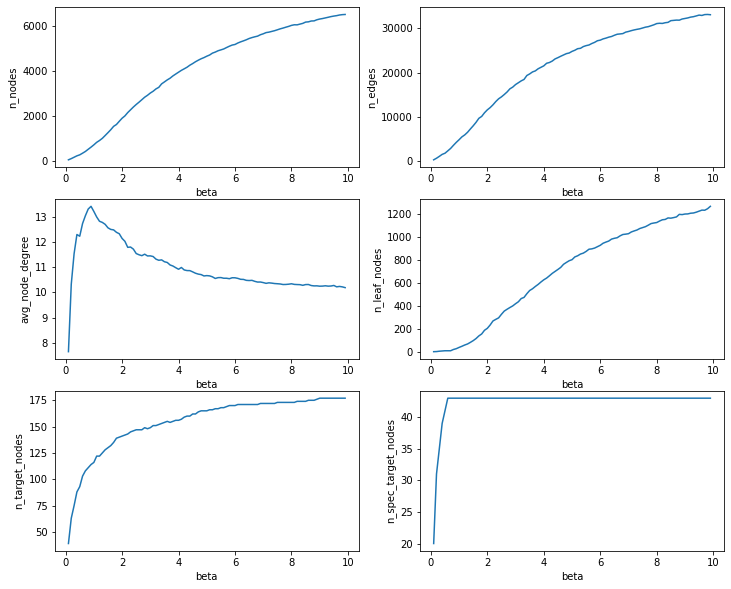

<IPython.core.display.Javascript object>

In [14]:
summarize_analyses_results_visually(conf_hub_augmented_pcst_mis_results)

Since we aim to simply learn the interactome that describe the individual specific ORF targets we choose the smallest graph solution that spans all those targets, which is obtained at $\beta$=0.6.

In [15]:
conf_hub_mis_sol = augmented_conf_hub_pcst_mis_dict[
    "augmented_conf_hub_ppi_b_0.6"
].copy()
conf_hub_mis_sol.name = "conf_hub_mis_sol"
print(nx.info(conf_hub_mis_sol))

Name: conf_hub_mis_sol
Type: Graph
Number of nodes: 356
Number of edges: 2267
Average degree:  12.7360


<IPython.core.display.Javascript object>

The corresponding network consists of 356 nodes with an average degree of 12.74 stemming from 2'267 edges. The network covers all 43 structural regulator genes covered in the input graph.

The above network is relatively small. After embedding the network we will be only able to predict alterations of the regulatory structure within in the space spanned by the genes covered in this network. Thus, we will also provide a larger network that is obtained by choosing exactly two times the minimum required $\beta$ to further outgrow the network and thus not only span the minimal network to cover the 40 specific ORF targets.

In [16]:
conf_hub_mis_sol_ext = augmented_conf_hub_pcst_mis_dict[
    "augmented_conf_hub_ppi_b_1.2"
].copy()
conf_hub_mis_sol_ext.name = "conf_hub_mis_sol_ext"
print(nx.info(conf_hub_mis_sol_ext))

Name: conf_hub_mis_sol_ext
Type: Graph
Number of nodes: 917
Number of edges: 5881
Average degree:  12.8266


<IPython.core.display.Javascript object>

---

#### 2.1.b. Spearman correlation edge weights

After having inferred the solution for the ``conf_hub_ppi`` input using the MINT-score inspired edge costs, we will now rerun the analyses using $1-r_{Spearman}$ as an alternative edge weight defintion. The intuition is that this will further guide the derivation of the interactome to focus on links that are specific to our cell-type of interest. On the flip side the metric were computed on noisy scRNAseq data which might limit the descriptive power of this metric to evaluate the strength of a regulatory link.

Since the Spearman-based edge weights are in the range of [0,1] compared to those previously used for MINT score based ones [0,0.562], we will run the screen for $\beta \in$ [0,20].

In [4]:
bs = np.arange(0.1, 20, 0.1)

<IPython.core.display.Javascript object>

In [5]:
(
    conf_hub_pcst_spearman_dict,
    augmented_conf_hub_pcst_spearman_dict,
) = run_pcst_sensitivity_analyses(
    graph=conf_hub_ppi,
    bs=bs,
    prize_key="prize",
    weight_key="spearmanr",
    minmax_scale=True,
)

Compute PCSTs: 100%|██████████| 199/199 [00:13<00:00, 14.51it/s]


<IPython.core.display.Javascript object>

In [6]:
conf_hub_augmented_pcst_spearman_results = analyze_pcst_sensitivity_analyses_results(
    augmented_conf_hub_pcst_spearman_dict,
    target_nodes=orf_targets,
    spec_targets=specific_targets,
)
conf_hub_augmented_pcst_spearman_results.loc[
    conf_hub_augmented_pcst_spearman_results["n_spec_target_nodes"]
    == np.max(conf_hub_augmented_pcst_spearman_results["n_spec_target_nodes"])
].sort_values("beta")

Analyze tree:   0%|          | 0/199 [00:00<?, ?it/s]/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.

,beta,n_nodes,n_edges,n_connected_components,n_louvain_clusters,avg_node_degree,std_node_degree,n_leaf_nodes,n_target_nodes,n_spec_target_nodes,n_spec_target_leafs,avg_spec_target_degree,std_spec_target_degree
augmented_conf_hub_ppi_b_2.6,2.6,244,521,1,9,4.270492,4.080214,54,51,43,9,5.116279,4.789569
augmented_conf_hub_ppi_b_2.7,2.7,270,576,1,10,4.266667,4.146752,61,52,43,8,5.372093,4.997782
augmented_conf_hub_ppi_b_2.8,2.8,297,663,1,11,4.464646,4.303267,67,53,43,7,5.767442,5.433904
augmented_conf_hub_ppi_b_2.9,2.9,323,746,1,10,4.619195,4.386216,72,53,43,7,6.023256,5.546792
augmented_conf_hub_ppi_b_3.0,3.0,342,766,1,9,4.479532,4.303323,77,54,43,8,6.023256,5.736413
...,...,...,...,...,...,...,...,...,...,...,...,...,...
augmented_conf_hub_ppi_b_19.5,19.5,5751,25988,1,25,9.037733,14.608951,1272,150,43,1,34.465116,33.789601
augmented_conf_hub_ppi_b_19.6,19.6,5766,26134,1,22,9.064863,14.672478,1272,151,43,1,34.534884,33.898171
augmented_conf_hub_ppi_b_19.7,19.7,5776,26179,1,26,9.064751,14.674255,1274,151,43,1,34.581395,33.941285
augmented_conf_hub_ppi_b_19.8,19.8,5791,26270,1,24,9.072699,14.688396,1279,152,43,1,34.581395,33.941285


<IPython.core.display.Javascript object>

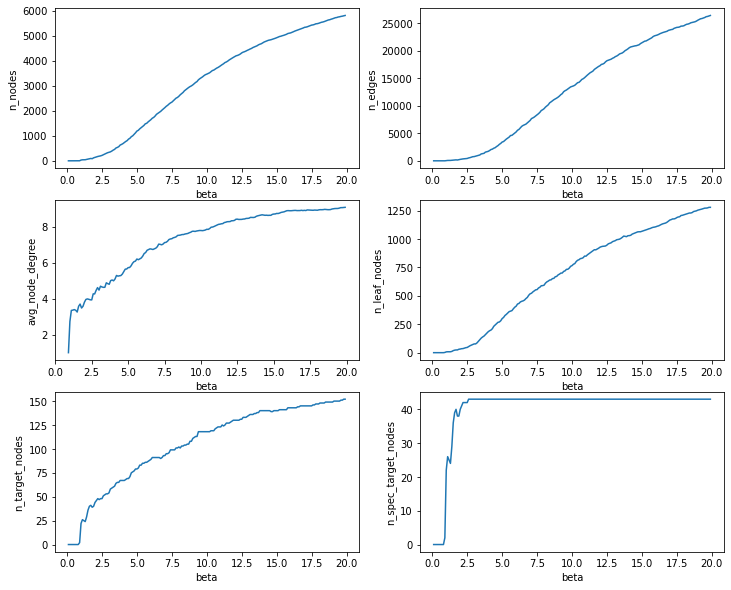

<IPython.core.display.Javascript object>

In [21]:
summarize_analyses_results_visually(conf_hub_augmented_pcst_spearman_results)

Using the Spearman-correlation based ede weights we see much smaller rate of increase of the number of edges and nodes for the different choices of $\beta$. This can be explained by the heavily left-skewed distribution of the Spearman edge weights when compared to the more uniformly distributed MINT score based edge weights used previously. We see that for a choice of $\beta \geq 2.6$ all 43 specific ORF targets are covered. Thus, we choose the corresponding graph as the solution of this setup.

In [22]:
conf_hub_spearman_sol = augmented_conf_hub_pcst_spearman_dict[
    "augmented_conf_hub_ppi_b_2.6"
].copy()
conf_hub_spearman_sol.name = "conf_hub_spearman_sol"
print(nx.info(conf_hub_spearman_sol))

Name: conf_hub_spearman_sol
Type: Graph
Number of nodes: 244
Number of edges: 521
Average degree:   4.2705


<IPython.core.display.Javascript object>

The selected network consists of 224 nodes with an average degree of 4.27 stemming from 521 edges. It is much sparser compared to the solution obtained by using the MIscore edge weights.

Similar as previously we also derive a network that is further outgrown by selecting the network obtained for two times the minimum $\beta$ value to span all 43 specific ORF targets.

In [23]:
conf_hub_spearman_sol_ext = augmented_conf_hub_pcst_spearman_dict[
    "augmented_conf_hub_ppi_b_5.2"
].copy()
conf_hub_spearman_sol_ext.name = "conf_hub_spearman_sol_ext"
print(nx.info(conf_hub_spearman_sol_ext))

Name: conf_hub_spearman_sol_ext
Type: Graph
Number of nodes: 1276
Number of edges: 3718
Average degree:   5.8276


<IPython.core.display.Javascript object>

---

#### 2.1.c. Comparison of the MIscore and Spearman edge cost solutions

To compare the solutions with the ones obtained previously for the MINT score based edge weights, we will look at the IoU of the nodes set of those two for the different choices of $\beta$.

100%|██████████| 99/99 [01:43<00:00,  1.05s/it]


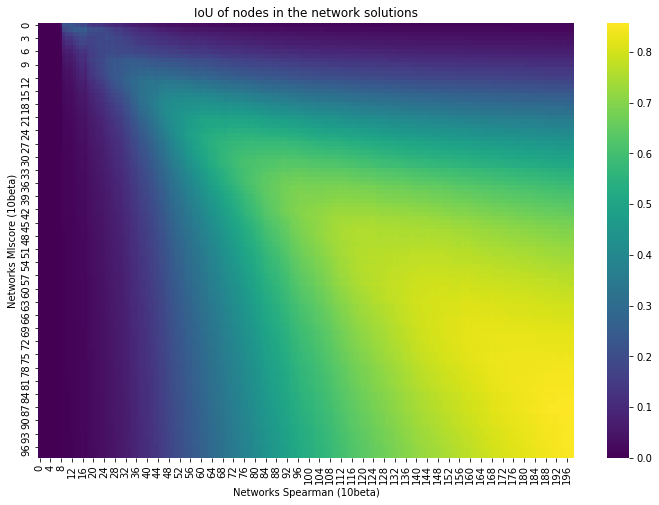

<IPython.core.display.Javascript object>

In [24]:
fig, ax, mis_spearman_node_ious = plot_solution_node_ious(
    augmented_conf_hub_pcst_mis_dict,
    augmented_conf_hub_pcst_spearman_dict,
    xlabel="Networks Spearman (10beta)",
    ylabel="Networks MIscore (10beta)",
)
plt.show()

As seen in the above plot the IoU is becomes relatively high for large $\beta$ values, i.e. for $\beta \geq (4,12)$ for the MIscore based edge weights and the Spearman edge weights respectively. The networks associated with those span 3892 respectively 4109 out 8902 nodes of the ``conf_hub_ppi``. Additionally it covers roughly 50% respectively 40% of all edges in the input graph.

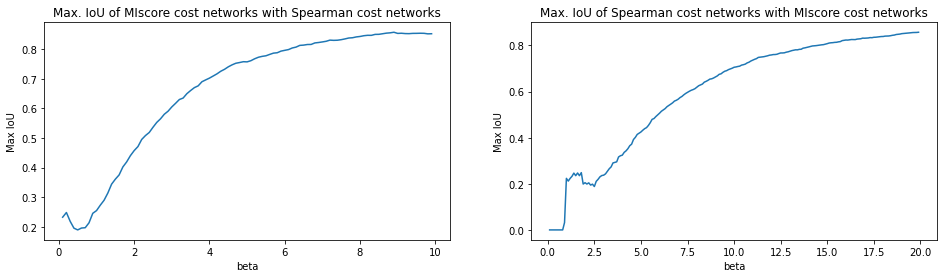

<IPython.core.display.Javascript object>

In [26]:
fig, ax = plt.subplots(ncols=2, figsize=[16, 4])
ax = ax.flatten()
ax[0].plot(np.arange(0.1, 10, 0.1), np.max(mis_spearman_node_ious, axis=1))
ax[0].set_xlabel("beta")
ax[0].set_ylabel("Max IoU")
ax[0].set_title("Max. IoU of MIscore cost networks with Spearman cost networks")
ax[1].plot(np.arange(0.1, 20, 0.1), np.max(mis_spearman_node_ious, axis=0))
ax[1].set_xlabel("beta")
ax[1].set_ylabel("Max IoU")
ax[1].set_title("Max. IoU of Spearman cost networks with MIscore cost networks")
plt.show()

The plots above also indicate that for choices of $\beta \leq (2.1, 5.9)$ the IoU of the node sets is upper bounded by 0.5.

This shows, that the PCST solutions for moderate choices of $\beta$ are quite different. Thus, we will consider both solutions in our further anlayses, i.e. the networks obtained for a choice of $\beta=0.6$ for the MIscore edge cost network and $\beta=2.6$ for the Spearman correlation edge cost network.

---

### 2.2 Confidence-hub3 network

Next, we analyze perform a similar set of analyses but using the ``conf_hub3_ppi`` as an input graph that relates to less conservative hub-node prunning.

#### 2.2.a. MINT score edge weights

In [27]:
bs = np.arange(0.1, 10, 0.1)

<IPython.core.display.Javascript object>

In [28]:
(
    conf_hub3_pcst_mis_dict,
    augmented_conf_hub3_pcst_mis_dict,
) = run_pcst_sensitivity_analyses(
    graph=conf_hub3_ppi,
    bs=bs,
    prize_key="prize",
    weight_key="mi_score",
    minmax_scale=True,
)

Compute PCSTs: 100%|██████████| 99/99 [00:06<00:00, 15.03it/s]


<IPython.core.display.Javascript object>

In [29]:
conf_hub3_augmented_pcst_mis_results = analyze_pcst_sensitivity_analyses_results(
    augmented_conf_hub3_pcst_mis_dict,
    target_nodes=orf_targets,
    spec_targets=specific_targets,
)
conf_hub3_augmented_pcst_mis_results.loc[
    conf_hub3_augmented_pcst_mis_results["n_spec_target_nodes"]
    == np.max(conf_hub3_augmented_pcst_mis_results["n_spec_target_nodes"])
].sort_values("beta")

Analyze tree: 100%|██████████| 99/99 [01:24<00:00,  1.17it/s]


,beta,n_nodes,n_edges,n_connected_components,n_louvain_clusters,avg_node_degree,std_node_degree,n_leaf_nodes,n_target_nodes,n_spec_target_nodes,n_spec_target_leafs,avg_spec_target_degree,std_spec_target_degree
augmented_conf_hub3_ppi_b_0.6,0.6,376,2884,1,7,15.340426,13.344696,8,105,43,3,13.837209,12.632425
augmented_conf_hub3_ppi_b_0.7,0.7,449,3535,1,9,15.746102,14.072597,7,110,43,3,14.860465,13.712295
augmented_conf_hub3_ppi_b_0.8,0.8,562,4398,1,10,15.651246,14.986212,19,113,43,2,16.279070,14.826635
augmented_conf_hub3_ppi_b_0.9,0.9,659,5121,1,9,15.541730,15.504447,26,115,43,2,16.976744,15.461112
augmented_conf_hub3_ppi_b_1.0,1.0,755,5796,1,9,15.353642,15.957335,35,118,43,2,17.930233,16.666908
...,...,...,...,...,...,...,...,...,...,...,...,...,...
augmented_conf_hub3_ppi_b_9.5,9.5,6488,35223,1,28,10.857891,18.771933,1215,178,43,1,40.744186,39.836347
augmented_conf_hub3_ppi_b_9.6,9.6,6483,35174,1,30,10.851149,18.804618,1230,179,43,1,40.837209,40.016235
augmented_conf_hub3_ppi_b_9.7,9.7,6514,35323,1,24,10.845256,18.802424,1232,178,43,1,40.837209,40.072568
augmented_conf_hub3_ppi_b_9.8,9.8,6522,35299,1,22,10.824594,18.780856,1244,178,43,1,40.860465,40.113549


<IPython.core.display.Javascript object>

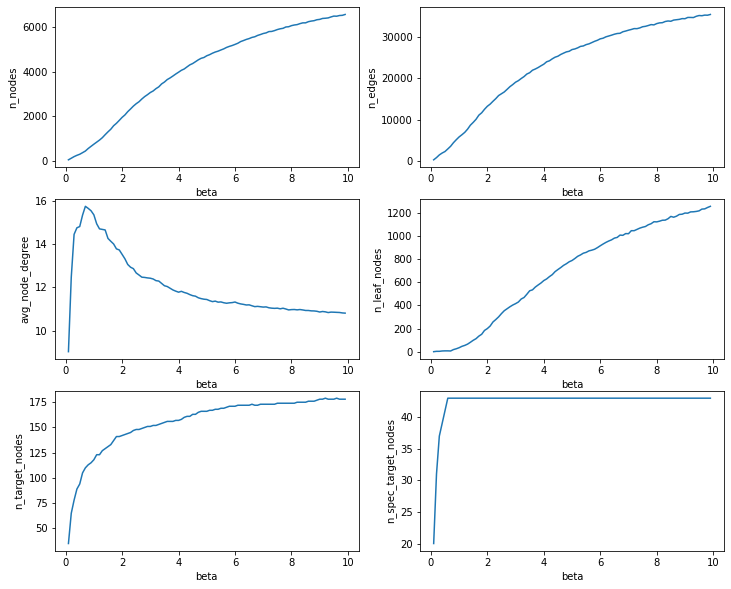

<IPython.core.display.Javascript object>

In [30]:
summarize_analyses_results_visually(conf_hub3_augmented_pcst_mis_results)

The analyses results look very similar to the ones we obtained for input network were we have pruned away more of the hubnodes. To quantify this we once again look at the IoU of the node sets for the two solution sets.

100%|██████████| 99/99 [01:06<00:00,  1.48it/s]


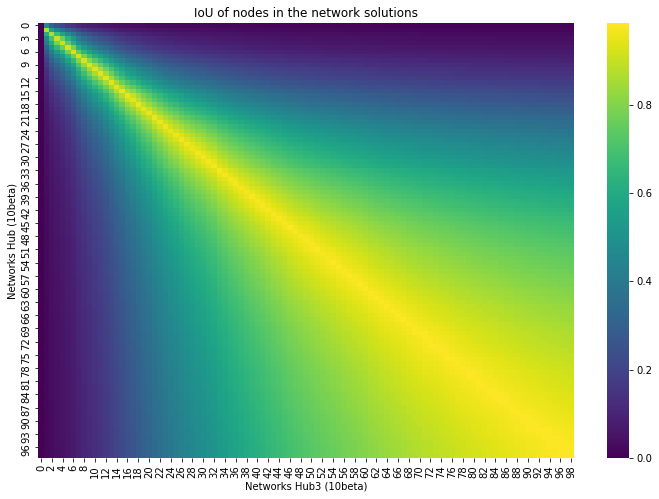

<IPython.core.display.Javascript object>

In [31]:
fig, ax, mis_hub_hub3_node_ious = plot_solution_node_ious(
    augmented_conf_hub_pcst_mis_dict,
    augmented_conf_hub3_pcst_mis_dict,
    xlabel="Networks Hub3 (10beta)",
    ylabel="Networks Hub (10beta)",
)
plt.show()

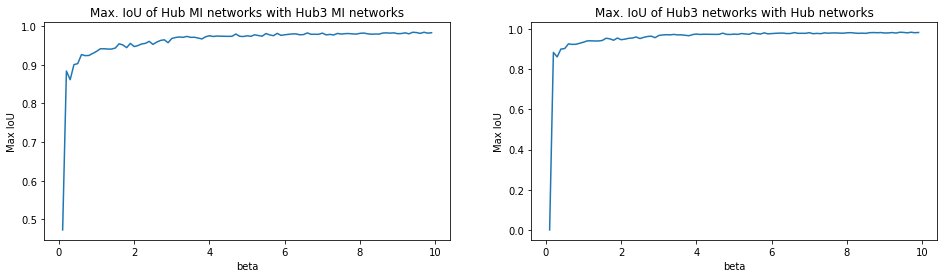

<IPython.core.display.Javascript object>

In [33]:
fig, ax = plt.subplots(ncols=2, figsize=[16, 4])
ax = ax.flatten()
ax[0].plot(np.arange(0.1, 10, 0.1), np.max(mis_hub_hub3_node_ious, axis=1))
ax[0].set_xlabel("beta")
ax[0].set_ylabel("Max IoU")
ax[0].set_title("Max. IoU of Hub MI networks with Hub3 MI networks")
ax[1].plot(np.arange(0.1, 10, 0.1), np.max(mis_hub_hub3_node_ious, axis=0))
ax[1].set_xlabel("beta")
ax[1].set_ylabel("Max IoU")
ax[1].set_title("Max. IoU of Hub3 networks with Hub networks")
plt.show()

We see that indeed the solutions seem to dependvery little on whether or not we pruned away only the top 3 nodes or the ones in the 0.28-percentile of the degree distribution for the confidence pruned input graph.

Note that the overlap of the node set is not a perfect proxy for the similarity of the subnetworks as for a stricter hubnode prunning we might have also removed more edges from the input graph that consequently will not be selected.

For simplicity we again choose $\beta=0.6$ which yields us a network spanning 375 nodes with an average degree of 13.85 stemming from 2'872 edges. The network covers 43/44 ORF targets.

In [34]:
conf_hub3_augmented_pcst_mis_results.loc["augmented_conf_hub3_ppi_b_0.6"]

beta                         0.600000
n_nodes                    376.000000
n_edges                   2884.000000
n_connected_components       1.000000
n_louvain_clusters           7.000000
avg_node_degree             15.340426
std_node_degree             13.344696
n_leaf_nodes                 8.000000
n_target_nodes             105.000000
n_spec_target_nodes         43.000000
n_spec_target_leafs          3.000000
avg_spec_target_degree      13.837209
std_spec_target_degree      12.632425
Name: augmented_conf_hub3_ppi_b_0.6, dtype: float64

<IPython.core.display.Javascript object>

---

#### 2.2.b. Spearman network

In [36]:
bs = np.arange(0.1, 20, 0.1)

<IPython.core.display.Javascript object>

In [37]:
(
    conf_hub3_pcst_spearman_dict,
    augmented_conf_hub3_pcst_spearman_dict,
) = run_pcst_sensitivity_analyses(
    graph=conf_hub3_ppi,
    bs=bs,
    prize_key="prize",
    weight_key="spearmanr",
    minmax_scale=True,
)

Compute PCSTs: 100%|██████████| 199/199 [00:14<00:00, 14.08it/s]


<IPython.core.display.Javascript object>

In [38]:
conf_hub3_augmented_pcst_spearman_results = analyze_pcst_sensitivity_analyses_results(
    augmented_conf_hub3_pcst_spearman_dict,
    target_nodes=orf_targets,
    spec_targets=specific_targets,
)
conf_hub3_augmented_pcst_spearman_results.loc[
    conf_hub3_augmented_pcst_spearman_results["n_spec_target_nodes"]
    == np.max(conf_hub3_augmented_pcst_spearman_results["n_spec_target_nodes"])
].sort_values("beta")

Analyze tree:   0%|          | 0/199 [00:00<?, ?it/s]/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.

,beta,n_nodes,n_edges,n_connected_components,n_louvain_clusters,avg_node_degree,std_node_degree,n_leaf_nodes,n_target_nodes,n_spec_target_nodes,n_spec_target_leafs,avg_spec_target_degree,std_spec_target_degree
augmented_conf_hub3_ppi_b_2.6,2.6,244,541,1,10,4.434426,4.304949,52,51,43,9,5.232558,4.888702
augmented_conf_hub3_ppi_b_2.7,2.7,270,597,1,9,4.422222,4.382569,59,52,43,8,5.488372,5.100716
augmented_conf_hub3_ppi_b_2.8,2.8,291,656,1,11,4.508591,4.505334,66,53,43,7,5.720930,5.354092
augmented_conf_hub3_ppi_b_2.9,2.9,325,768,1,10,4.726154,4.633200,72,54,43,7,6.093023,5.668411
augmented_conf_hub3_ppi_b_3.0,3.0,345,793,1,9,4.597101,4.583207,79,56,43,8,6.116279,5.859634
...,...,...,...,...,...,...,...,...,...,...,...,...,...
augmented_conf_hub3_ppi_b_19.5,19.5,5790,27800,1,33,9.602763,16.999575,1263,151,43,1,35.534884,34.599603
augmented_conf_hub3_ppi_b_19.6,19.6,5805,27947,1,26,9.628596,17.051239,1263,152,43,1,35.604651,34.708849
augmented_conf_hub3_ppi_b_19.7,19.7,5815,27994,1,25,9.628203,17.052426,1265,152,43,1,35.651163,34.754209
augmented_conf_hub3_ppi_b_19.8,19.8,5832,28097,1,28,9.635460,17.064767,1268,153,43,1,35.651163,34.754209


<IPython.core.display.Javascript object>

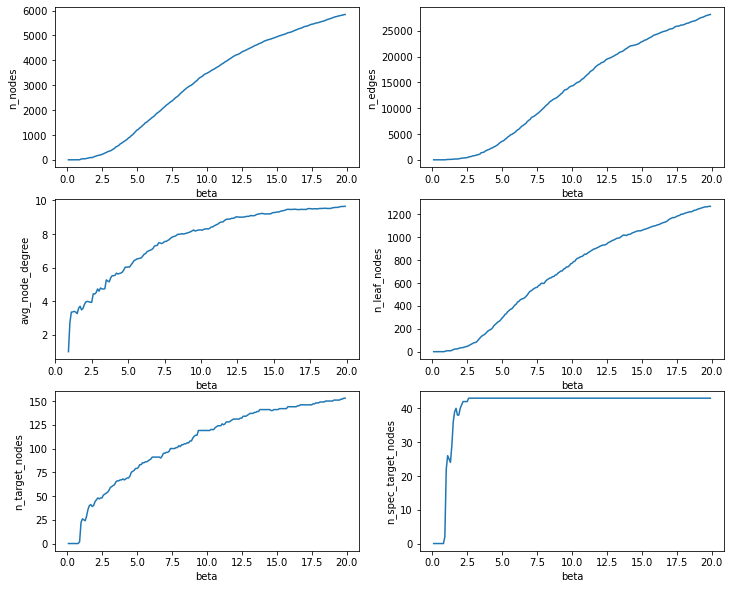

<IPython.core.display.Javascript object>

In [39]:
summarize_analyses_results_visually(conf_hub3_augmented_pcst_spearman_results)

Again the results look highly similar to the ones using the ``conf_hub_ppi`` as input. We further illustrate that by looking at the node IoU for the two setups.

100%|██████████| 199/199 [03:04<00:00,  1.08it/s]


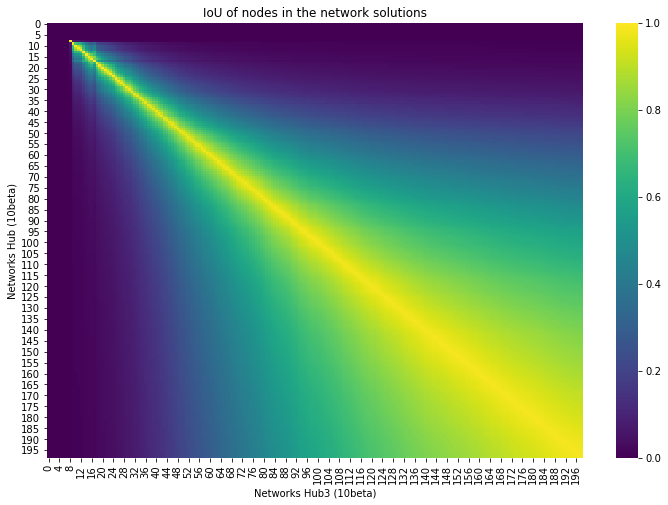

<IPython.core.display.Javascript object>

In [40]:
fig, ax, spearman_hub_hub3_node_ious = plot_solution_node_ious(
    augmented_conf_hub_pcst_spearman_dict,
    augmented_conf_hub3_pcst_spearman_dict,
    xlabel="Networks Hub3 (10beta)",
    ylabel="Networks Hub (10beta)",
)
plt.show()

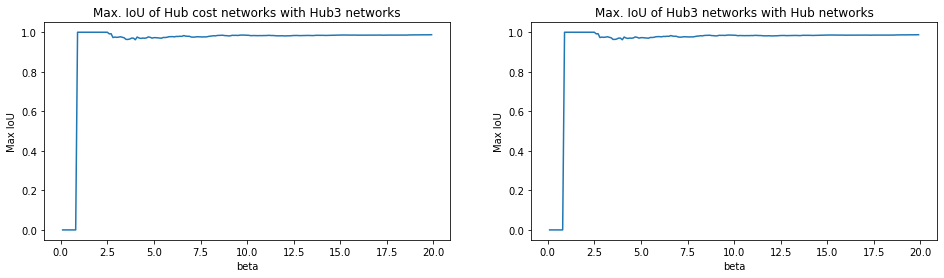

<IPython.core.display.Javascript object>

In [41]:
fig, ax = plt.subplots(ncols=2, figsize=[16, 4])
ax = ax.flatten()
ax[0].plot(np.arange(0.1, 20, 0.1), np.max(spearman_hub_hub3_node_ious, axis=1))
ax[0].set_xlabel("beta")
ax[0].set_ylabel("Max IoU")
ax[0].set_title("Max. IoU of Hub cost networks with Hub3 networks")
ax[1].plot(np.arange(0.1, 20, 0.1), np.max(spearman_hub_hub3_node_ious, axis=0))
ax[1].set_xlabel("beta")
ax[1].set_ylabel("Max IoU")
ax[1].set_title("Max. IoU of Hub3 networks with Hub networks")
plt.show()

We see that for Spearman correlation based networks the selected node sets are even more similar as for the networks computed based on the two different input graphs using the MIscore -based edge weights.

---

### 2.3. Hub network

#### 2.3.a.  MIscore edge weights

In [42]:
bs = np.arange(0.1, 10, 0.1)

<IPython.core.display.Javascript object>

In [43]:
(hub_pcst_mis_dict, augmented_hub_pcst_mis_dict,) = run_pcst_sensitivity_analyses(
    graph=hub_ppi,
    bs=bs,
    prize_key="prize",
    weight_key="mi_score",
    minmax_scale=True,
)

Compute PCSTs: 100%|██████████| 99/99 [00:17<00:00,  5.56it/s]


<IPython.core.display.Javascript object>

In [44]:
hub_augmented_pcst_mis_results = analyze_pcst_sensitivity_analyses_results(
    augmented_hub_pcst_mis_dict,
    target_nodes=orf_targets,
    spec_targets=specific_targets,
)
hub_augmented_pcst_mis_results.loc[
    hub_augmented_pcst_mis_results["n_spec_target_nodes"]
    == np.max(hub_augmented_pcst_mis_results["n_spec_target_nodes"])
].sort_values("beta")

Analyze tree: 100%|██████████| 99/99 [03:07<00:00,  1.89s/it]


,beta,n_nodes,n_edges,n_connected_components,n_louvain_clusters,avg_node_degree,std_node_degree,n_leaf_nodes,n_target_nodes,n_spec_target_nodes,n_spec_target_leafs,avg_spec_target_degree,std_spec_target_degree
augmented_hub_ppi_b_0.9,0.9,629,8084,1,7,25.704293,22.261740,10,113,44,2,27.886364,23.351286
augmented_hub_ppi_b_1.0,1.0,723,9536,1,8,26.378976,23.787620,13,117,44,2,30.045455,25.562717
augmented_hub_ppi_b_1.1,1.1,817,10730,1,7,26.266830,24.508681,16,122,44,2,31.477273,26.819674
augmented_hub_ppi_b_1.2,1.2,915,12026,1,7,26.286339,25.372697,20,122,44,2,33.545455,28.696258
augmented_hub_ppi_b_1.3,1.3,1041,14147,1,7,27.179635,26.855886,28,127,44,2,36.113636,31.000891
...,...,...,...,...,...,...,...,...,...,...,...,...,...
augmented_hub_ppi_b_9.5,9.5,7790,93659,1,11,24.045956,40.756759,792,178,44,0,84.022727,76.460771
augmented_hub_ppi_b_9.6,9.6,7834,94067,1,14,24.015063,40.775865,795,178,44,0,84.250000,76.830725
augmented_hub_ppi_b_9.7,9.7,7852,94301,1,14,24.019613,40.810783,803,178,44,0,84.318182,77.127631
augmented_hub_ppi_b_9.8,9.8,7874,94362,1,15,23.967996,40.751276,812,178,44,0,84.340909,76.911975


<IPython.core.display.Javascript object>

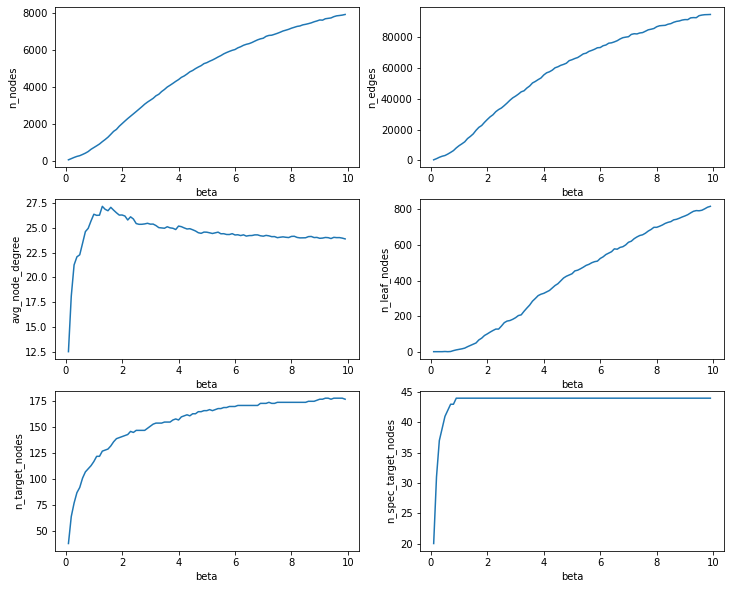

<IPython.core.display.Javascript object>

In [45]:
summarize_analyses_results_visually(hub_augmented_pcst_mis_results)

#### 2.3.b. Comparison with the ``conf_hub_ppi`` solution

For that configuration we do not aim to infer the network using the Spearman correlation as an edge weight as this will likely capture low-confidence edges which we do not want to include in the solution. Instead, we are directly looking at the similarity of the derived networks with the ones we obtained using the ``conf_hub_ppi`` as input.

100%|██████████| 99/99 [01:06<00:00,  1.49it/s]


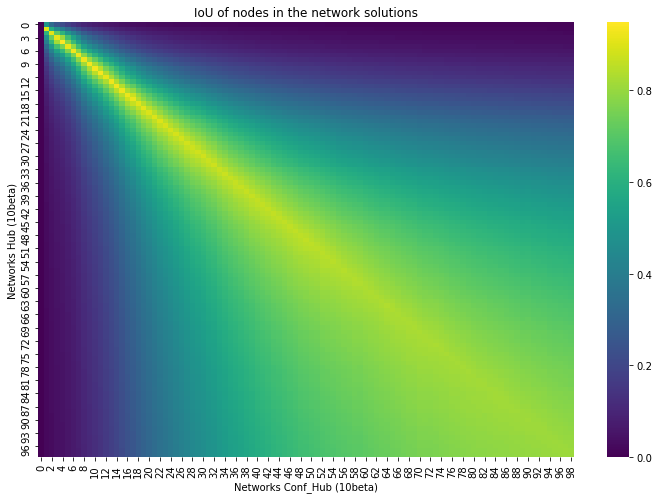

<IPython.core.display.Javascript object>

In [46]:
fig, ax, mis_conf_hub_hub_node_ious = plot_solution_node_ious(
    augmented_conf_hub_pcst_mis_dict,
    augmented_hub_pcst_mis_dict,
    xlabel="Networks Conf_Hub (10beta)",
    ylabel="Networks Hub (10beta)",
)
plt.show()

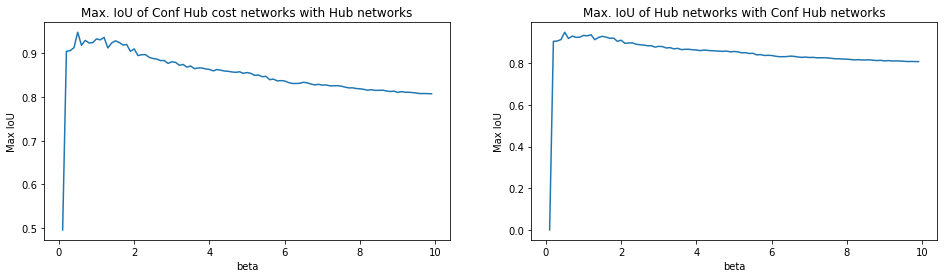

<IPython.core.display.Javascript object>

In [47]:
fig, ax = plt.subplots(ncols=2, figsize=[16, 4])
ax = ax.flatten()
ax[0].plot(np.arange(0.1, 10, 0.1), np.max(mis_conf_hub_hub_node_ious, axis=1))
ax[0].set_xlabel("beta")
ax[0].set_ylabel("Max IoU")
ax[0].set_title("Max. IoU of Conf Hub cost networks with Hub networks")
ax[1].plot(np.arange(0.1, 10, 0.1), np.max(mis_conf_hub_hub_node_ious, axis=0))
ax[1].set_xlabel("beta")
ax[1].set_ylabel("Max IoU")
ax[1].set_title("Max. IoU of Hub networks with Conf Hub networks")
plt.show()

We see that again for moderate sizes of $\beta$ the agreement of the node sets is very high for the different input graphs. This suggests that are derived network for our choice of $\beta=0.6$ using the ``conf_hub_ppi`` as input is relatively stable for different choices of input graphs. We will thus proceed focussing on that network.

---

## 3. Output U2OS interactome candidate

Based on our previous analyses, we select our four interactome candidates.

The first network is the one that we obtained by that we obtained for $\beta=0.6$ by running the PCST using the ``conf_hub_ppi`` as the input graph with the prizes being the min-max scaled absolute log fold-changes from the marker screen based on the CCLE data set and the edge weights being given by the $1-m(e)$ where $m(e)$ is the MINT-inspired score for the interaction of the nodes connected by edge $e$.

The second network is the one that we obtained for the same setup but selecting $\beta=1.2$ to further outgrow the network.

The third and forth network are obtained by a similar setup but the edge weights are here given by $1-m(e)$ where $(e)$ is the absolute Spearman correlation of the scRNAseq data between the two genes.

In [48]:
print(nx.info(conf_hub_mis_sol))

print("")
print(nx.info(conf_hub_spearman_sol))

Name: conf_hub_mis_sol
Type: Graph
Number of nodes: 356
Number of edges: 2267
Average degree:  12.7360

Name: conf_hub_spearman_sol
Type: Graph
Number of nodes: 244
Number of edges: 521
Average degree:   4.2705


<IPython.core.display.Javascript object>

In [49]:
output_dir = "../../../data/ppi/inference_results/"
os.makedirs(output_dir, exist_ok=True)
nx.write_graphml(
    conf_hub_mis_sol,
    os.path.join(output_dir, "{}_cv.graphml".format(conf_hub_mis_sol.name)),
)
nx.write_gpickle(
    conf_hub_mis_sol,
    os.path.join(output_dir, "{}_cv.pkl".format(conf_hub_mis_sol.name)),
)

<IPython.core.display.Javascript object>

In [50]:
nx.write_graphml(
    conf_hub_spearman_sol,
    os.path.join(output_dir, "{}_cv.graphml".format(conf_hub_spearman_sol.name)),
)
nx.write_gpickle(
    conf_hub_spearman_sol,
    os.path.join(output_dir, "{}_cv.pkl".format(conf_hub_spearman_sol.name)),
)

<IPython.core.display.Javascript object>

In [51]:
nx.write_graphml(
    conf_hub_spearman_sol_ext,
    os.path.join(output_dir, "{}_cv.graphml".format(conf_hub_spearman_sol_ext.name)),
)
nx.write_gpickle(
    conf_hub_spearman_sol_ext,
    os.path.join(output_dir, "{}_cv.pkl".format(conf_hub_spearman_sol_ext.name)),
)

<IPython.core.display.Javascript object>

In [52]:
nx.write_graphml(
    conf_hub_mis_sol_ext,
    os.path.join(output_dir, "{}_cv.graphml".format(conf_hub_mis_sol_ext.name)),
)
nx.write_gpickle(
    conf_hub_mis_sol_ext,
    os.path.join(output_dir, "{}_cv.pkl".format(conf_hub_mis_sol_ext.name)),
)

<IPython.core.display.Javascript object>